In [22]:
import os
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model



In [24]:
class TCL_trip():
  def get_null_count(self, df):
    column_names = list(df.columns)
    null_values = list(df.isnull().sum().values)
    ser = pd.Series(null_values,column_names)
    null_dict = {}
    for key, value in ser.items():
      if value !=0:
        null_dict[key] = value
    return null_dict
  def get_info(self, dataframe):
    dataframe = dataframe.reset_index()
    print("Basic information about dataset")
    print("-------------------------------------------------------------------------------------------")
    print(f"Number of Rows : {len(dataframe.index)}", end='\n\n')
    print(f"{dataframe.index}", end ="\n\n")
    print(f"Number of columns :{len(dataframe.columns)}", end='\n\n')
    print(f"column Name : {np.array(dataframe.columns)}", end='\n\n')
    print("Columns which has null values : ", self.get_null_count(dataframe), end='\n\n')

  def handle_null(self, data):
    data.dropna(subset=['passenger_count'], inplace=True)
    data = data[data['trip_distance'] != 0]
    data = data[data['passenger_count'] != 0]
    del data['airport_fee']
    return data

  def feature_eng(self, data):
    data['DO_year'] = data['tpep_dropoff_datetime'].dt.year
    data['DO_month'] = data['tpep_dropoff_datetime'].dt.month
    data['DO_day'] = data['tpep_dropoff_datetime'].dt.day
    data['DO_hour'] = data['tpep_dropoff_datetime'].dt.hour
    data['DO_minute'] = data['tpep_dropoff_datetime'].dt.minute
    data['DO_second'] = data['tpep_dropoff_datetime'].dt.second

    data['PU_year'] = data['tpep_pickup_datetime'].dt.year
    data['PU_month'] = data['tpep_pickup_datetime'].dt.month
    data['PU_day'] = data['tpep_pickup_datetime'].dt.day
    data['PU_hour'] = data['tpep_pickup_datetime'].dt.hour
    data['PU_minute'] = data['tpep_pickup_datetime'].dt.minute
    data['PU_second'] = data['tpep_pickup_datetime'].dt.second

    del data['tpep_dropoff_datetime']
    del data['tpep_pickup_datetime']

    return data

  def transdorm_to_numeric(self, data):
    data['store_and_fwd_flag'] = data['store_and_fwd_flag'].replace('Y', 1)
    data['store_and_fwd_flag'] = data['store_and_fwd_flag'].replace('N', 0)

    return data

  def convert_neg_amount(self, data):
    columns = ['fare_amount', 'extra',
                'mta_tax','tip_amount', 'tolls_amount', 'improvement_surcharge',
                'congestion_surcharge']
    for item in columns:
      data[item] = data[item].abs()
    data.loc[data['mta_tax'] != 0, 'mta_tax'] = 0.50
    data.loc[data['improvement_surcharge'] != 0, 'improvement_surcharge'] = 0.30
    data['total_amount'] = data['fare_amount']+data['extra']+data['mta_tax']+data['tip_amount']+data['tolls_amount']+data['improvement_surcharge']+data['congestion_surcharge']

    return data


  def load_jan_data(self):
    data = pd.read_parquet("/content/drive/MyDrive/Deep Learning/project2/yellow_tripdata_2020-01.parquet")
    data = self.handle_null(data)
    data = self.feature_eng(data)
    data = self.transdorm_to_numeric(data)
    data = self.convert_neg_amount(data)
    data.info()
    self.get_info(data)
    return data




In [25]:
class Weather():
  def get_null_count(self, df):
    column_names = list(df.columns)
    null_values = list(df.isnull().sum().values)
    ser = pd.Series(null_values,column_names)
    null_dict = {}
    for key, value in ser.items():
      if value !=0:
        null_dict[key] = value
    return null_dict
  def get_info(self, dataframe):
    dataframe = dataframe.reset_index()
    print("Basic information about dataset")
    print(dataframe.info())
    print("-------------------------------------------------------------------------------------------")
    print(f"Number of Rows : {len(dataframe.index)}", end='\n\n')
    print(f"{dataframe.index}", end ="\n\n")
    print(f"Number of columns :{len(dataframe.columns)}", end='\n\n')
    print(f"column Name : {np.array(dataframe.columns)}", end='\n\n')
    print("Columns which has null values : ", self.get_null_count(dataframe), end='\n\n')
    print("-------------------------------------------------------------------------------------------")

  def fill_missing_with_random(self, df, column):
    min_val = df[column].min()
    max_val = df[column].max()
    missing_count = df[column].isnull().sum()
    random_values = np.random.uniform(min_val, max_val, missing_count)
    random_values = np.round(random_values, 1)
    df.loc[df[column].isnull(), column] = random_values

  def handle_MV(self, df):
    print("Handling Missing values in ['tavg', 'tmin', 'tmax', 'wspd', 'pres'] columns : ")
    columns_with_missing = ['tavg', 'tmin', 'tmax', 'wspd', 'pres']

    rows_with_missing = df[df[columns_with_missing].isnull().any(axis=1)]
    print(rows_with_missing)

    for column in columns_with_missing:
      self.fill_missing_with_random(df, column)


    rows_to_display = df.iloc[[5, 10, 12, 26]]
    print(rows_to_display)

    print("-----------------------------------------------------------------------")
    print("Handling Missing values in 'wdir', 'snow' and 'prcp'")


    print(df['wdir'].head(8))

    wdir_values = [264.6, 218.2, 235.5, 325.2, 300.1, 239.2, 286, 269.5,
        272.3, 265.6, 192.7, 247.8, 13.4, 55, 269.4, 274.6,
        321.2, 187.3,269.1, 328.4, 323.7, 286.8, 227.1, 245.7,
        342.8, 265.6, 198.4, 230.4, 246.9, 251.2, 299]
    df['wdir'] = wdir_values
    print(df['wdir'].head(8))

    print("------------------------------------------------------------------------")
    print(df['snow'].iloc[3:8])
    df['date'] = pd.to_datetime(df['date'])
    df['snow'] = 0
    df.loc[6, 'snow'] = 30
    print(df['snow'].iloc[3:8])
    print("------------------------------------------------------------------------")
    print(df['prcp'].iloc[2:20])
    prcp_values =  {3 : 2.8,
            4: 5.3,
            6 : 0.8,
             12 : 1,
            14 : 0.5,
            16 : 1.3,
             18 : 7.9
            }
    df['prcp'] = 0
    for date, value in prcp_values.items():
      df.loc[date, 'prcp'] = value
    print(df['prcp'].iloc[2:20])

    del df['wpgt']
    del df['tsun']

  def weather_data_box_plot(self, data):
    columns = ['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'pres']
    for column in columns:
        plt.figure(figsize=(8, 6))
        data.boxplot(column=[column])
        plt.title(column)
        plt.show()
        print("-------------------------------------------------------------------------------------------------------------")



In [26]:
class Merged():
  def get_null_count(self, df):
    column_names = list(df.columns)
    null_values = list(df.isnull().sum().values)
    ser = pd.Series(null_values,column_names)
    null_dict = {}
    for key, value in ser.items():
      if value !=0:
        null_dict[key] = value
    return null_dict

  def get_info(self, dataframe):
    dataframe = dataframe.reset_index()
    print("Basic information about dataset")
    print(dataframe.info())
    print("-------------------------------------------------------------------------------------------")
    print(f"Number of Rows : {len(dataframe.index)}", end='\n\n')
    print(f"{dataframe.index}", end ="\n\n")
    print(f"Number of columns :{len(dataframe.columns)}", end='\n\n')
    print(f"column Name : {np.array(dataframe.columns)}", end='\n\n')
    print("Columns which has null values : ", self.get_null_count(dataframe), end='\n\n')
    print("-------------------------------------------------------------------------------------------")



## column discription :

- `index`: The index of the data entry.
- `Date`: The date of the recorded weather data.
- `Tavg`: Average Temperature in Celsius.
- `Tmin`: Minimum Temperature in Celsius.
- `Tmax`: Maximum Temperature in Celsius.
- `prcp`: Total Precipitation in millimeters.
- `snow`: Snow Depth.
- `wdir`: Wind (From) Direction.
- `Wspd`: Average Wind Speed in kilometers per hour.
- `Wpgt`: Wind Peak Gust in kilometers per hour.
- `pres`: Sea-Level Air Pressure in hectopascals (hPa).
- `Tsun`: Total Sunshine Duration in Minutes.

In [27]:
weather = pd.read_csv("/content/drive/MyDrive/Deep Learning/project2/export.csv")

Wtr = Weather()
Wtr.get_info(weather)


Basic information about dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   31 non-null     int64  
 1   date    31 non-null     object 
 2   tavg    28 non-null     float64
 3   tmin    28 non-null     float64
 4   tmax    28 non-null     float64
 5   prcp    0 non-null      float64
 6   snow    0 non-null      float64
 7   wdir    1 non-null      float64
 8   wspd    27 non-null     float64
 9   wpgt    0 non-null      float64
 10  pres    27 non-null     float64
 11  tsun    0 non-null      float64
dtypes: float64(10), int64(1), object(1)
memory usage: 3.0+ KB
None
-------------------------------------------------------------------------------------------
Number of Rows : 31

RangeIndex(start=0, stop=31, step=1)

Number of columns :12

column Name : ['index' 'date' 'tavg' 'tmin' 'tmax' 'prcp' 'snow' 'wdir' 'wspd' 'wpgt'
 'pres' 'tsun']

Co

- The dataset contains 31 rows of weather data.
- There are 12 columns in the dataset, including 'index', 'date', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', and 'tsun'.
- Three columns, 'tavg', 'tmin', and 'tmax', each have 3 null values and 'wspd' (wind speed), 'pres' (pressure) has 4 null values.
- The 'prcp' (precipitation), 'snow', 'wpgt' (peak wind gust) and 'tsun' (sunshine duration) columns have 31 null values, 'wdir' (wind direction) has 30 null values indicating missing data for every row.

In [28]:
weather.describe()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
count,28.000000,28.000000,28.000000,0.0,0.0,1.0,27.000000,0.0,27.000000,0.0
mean,4.225000,1.485714,7.496429,NaN,NaN,265.0,10.662963,NaN,1020.418519,NaN
std,3.795965,3.770128,3.636694,NaN,NaN,NaN,3.748451,NaN,9.635712,NaN
min,-2.200000,-5.000000,2.200000,NaN,NaN,265.0,5.700000,NaN,1003.700000,NaN
25%,2.275000,-0.875000,5.450000,NaN,NaN,265.0,8.300000,NaN,1012.050000,NaN
50%,4.650000,1.950000,7.200000,NaN,NaN,265.0,9.900000,NaN,1018.200000,NaN
75%,6.425000,3.450000,9.025000,NaN,NaN,265.0,11.550000,NaN,1027.950000,NaN
max,15.700000,9.400000,19.400000,NaN,NaN,265.0,22.900000,NaN,1038.800000,NaN


## Handling Missing Values

In [29]:
Wtr.handle_MV(weather)
Wtr.get_info(weather)

Handling Missing values in ['tavg', 'tmin', 'tmax', 'wspd', 'pres'] columns : 
          date  tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt  pres  tsun
5   2020-01-06   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
10  2020-01-11   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
12  2020-01-13   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
26  2020-01-27   5.1   3.3   8.3   NaN   NaN   NaN   NaN   NaN   NaN   NaN
          date  tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres  tsun
5   2020-01-06   2.0   7.5   3.0   NaN   NaN   NaN  12.8   NaN  1010.1   NaN
10  2020-01-11  12.8  -0.3   9.4   NaN   NaN   NaN  15.0   NaN  1008.8   NaN
12  2020-01-13   5.4   7.9   7.2   NaN   NaN   NaN  20.3   NaN  1025.1   NaN
26  2020-01-27   5.1   3.3   8.3   NaN   NaN   NaN   7.6   NaN  1021.2   NaN
-----------------------------------------------------------------------
Handling Missing values in 'wdir', 'snow' and 'prcp'
0   NaN
1   NaN
2   NaN
3   NaN
4   

- To address the limited size of the weather dataset with only 31 rows, representing daily weather reports, null values were filled in specific columns.
- For 'Tavg', 'Tmin', and 'Tmax', each having 3 null values, random numbers were generated within the range of their minimum and maximum values. For example, 'Tavg' ranging from -2.2 to 15.7 was filled with random values within this range.
- 'Wspd' and 'pres' columns, each with 4 null values, were also filled with random numbers within their respective observed ranges.
- 'Wdir' (wind direction) and 'prcp' (precipitation) columns were updated using a set of numbers referenced in the instruction manual.
- The 'snow' column, primarily filled with 0 values, had an exception on '2022-01-06' with a value of 30.
- Due to complete absence of data in the 'wpgt' (peak wind gust) and 'tsun' (sunshine duration) columns, both columns were dropped from the dataset to maintain data integrity.

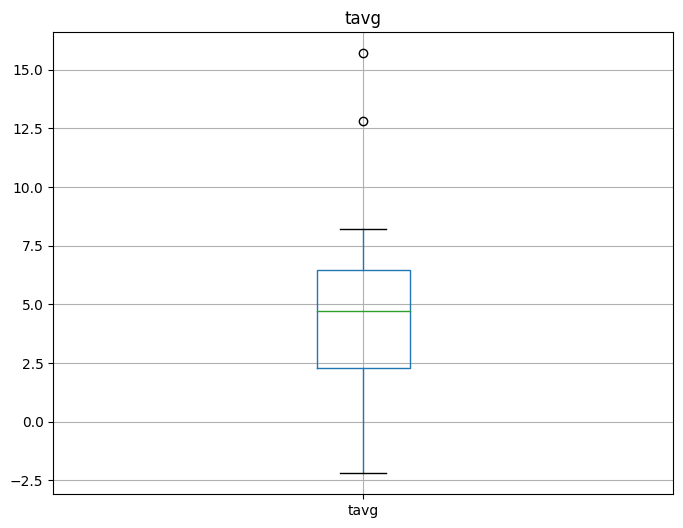

-------------------------------------------------------------------------------------------------------------


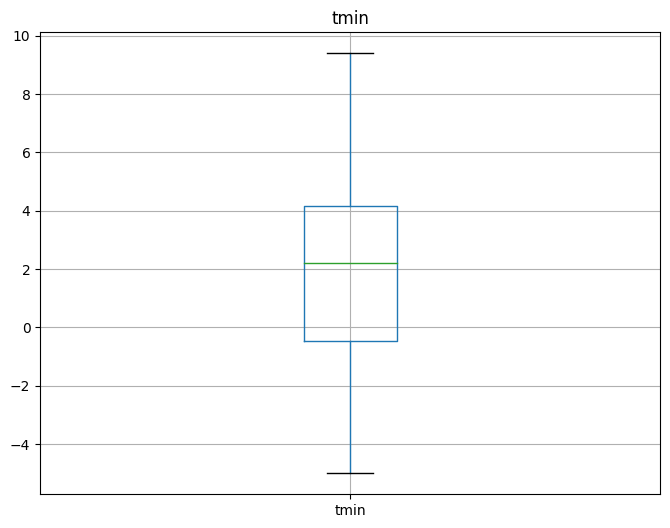

-------------------------------------------------------------------------------------------------------------


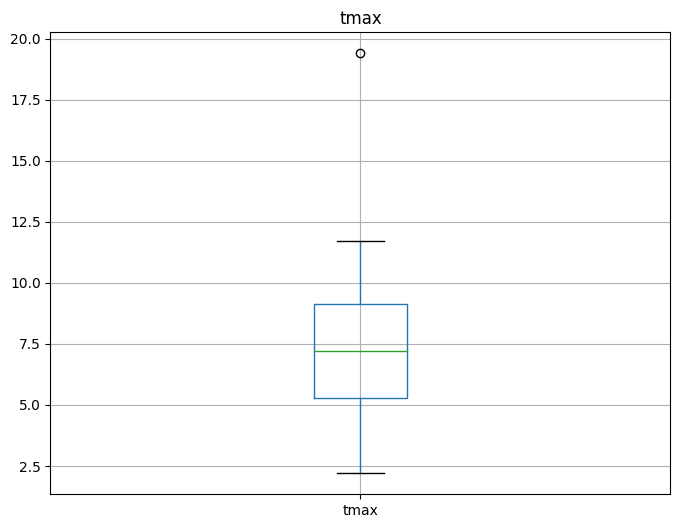

-------------------------------------------------------------------------------------------------------------


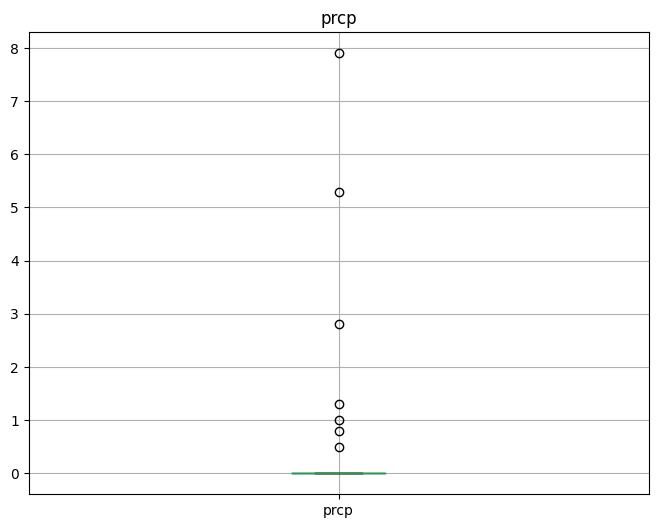

-------------------------------------------------------------------------------------------------------------


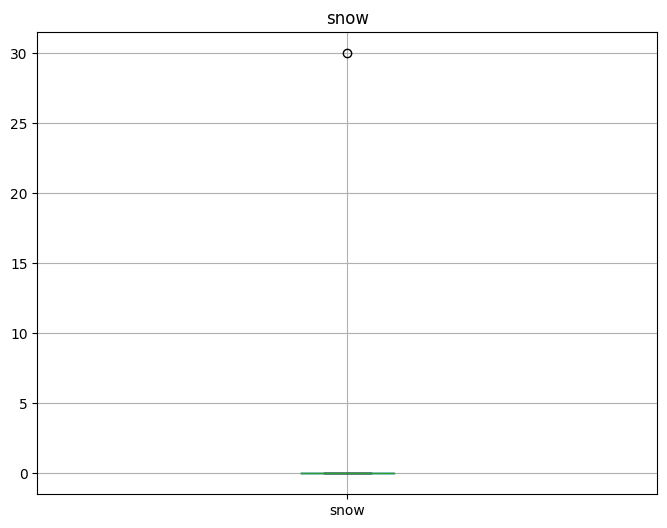

-------------------------------------------------------------------------------------------------------------


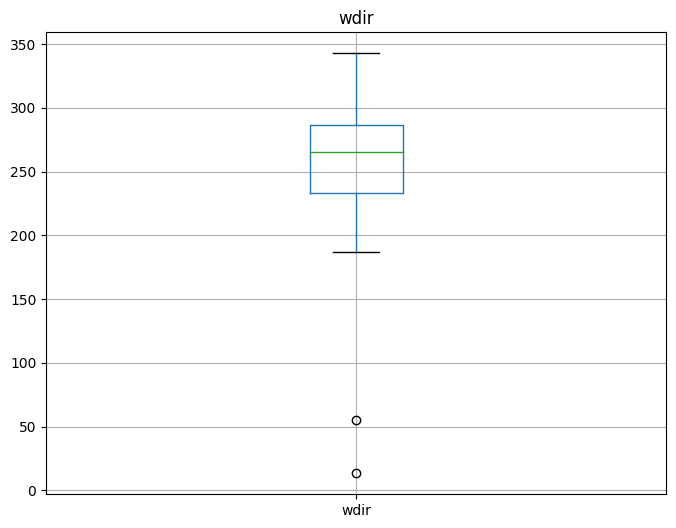

-------------------------------------------------------------------------------------------------------------


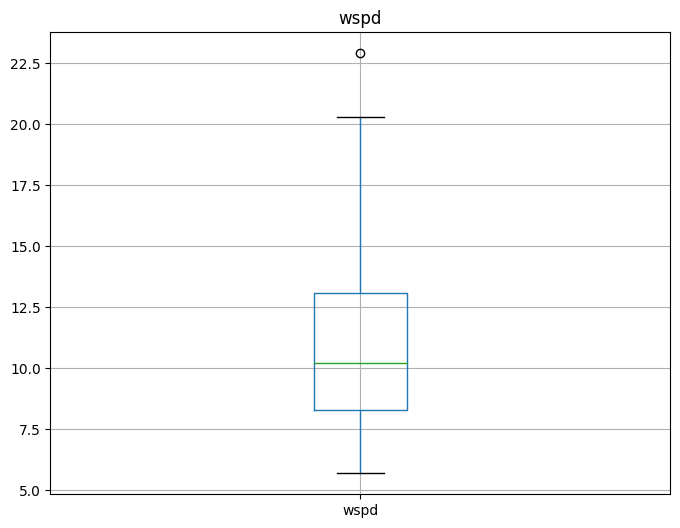

-------------------------------------------------------------------------------------------------------------


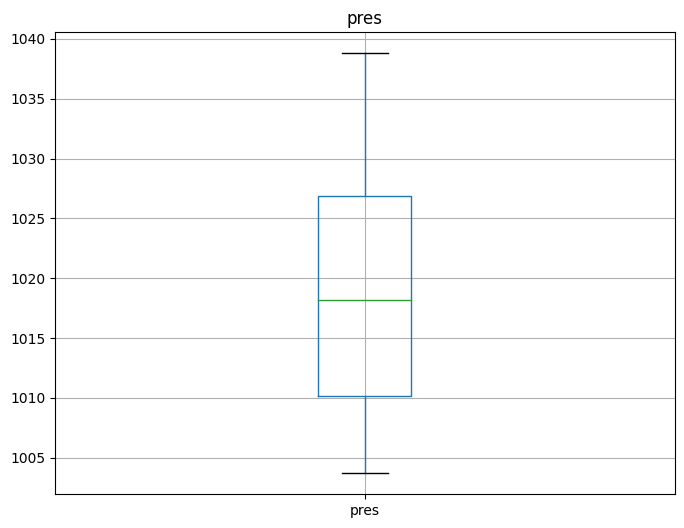

-------------------------------------------------------------------------------------------------------------


In [30]:
Wtr.weather_data_box_plot(weather)

## Loading Jan-2020 NYC Yellow Trip record:

In [31]:
ytt = TCL_trip()
yellow_taxi = ytt.load_jan_data()

<class 'pandas.core.frame.DataFrame'>
Index: 6159935 entries, 0 to 6339565
Data columns (total 28 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   passenger_count        float64
 2   trip_distance          float64
 3   RatecodeID             float64
 4   store_and_fwd_flag     int64  
 5   PULocationID           int64  
 6   DOLocationID           int64  
 7   payment_type           int64  
 8   fare_amount            float64
 9   extra                  float64
 10  mta_tax                float64
 11  tip_amount             float64
 12  tolls_amount           float64
 13  improvement_surcharge  float64
 14  total_amount           float64
 15  congestion_surcharge   float64
 16  DO_year                int32  
 17  DO_month               int32  
 18  DO_day                 int32  
 19  DO_hour                int32  
 20  DO_minute              int32  
 21  DO_second              int32  
 22  PU_year                

In [32]:
# Randomly sample 80% of the rows
sample = yellow_taxi.sample(frac=0.20, random_state=42)

# The remaining 20% will be deleted
deleted_rows = yellow_taxi.drop(yellow_taxi.index)

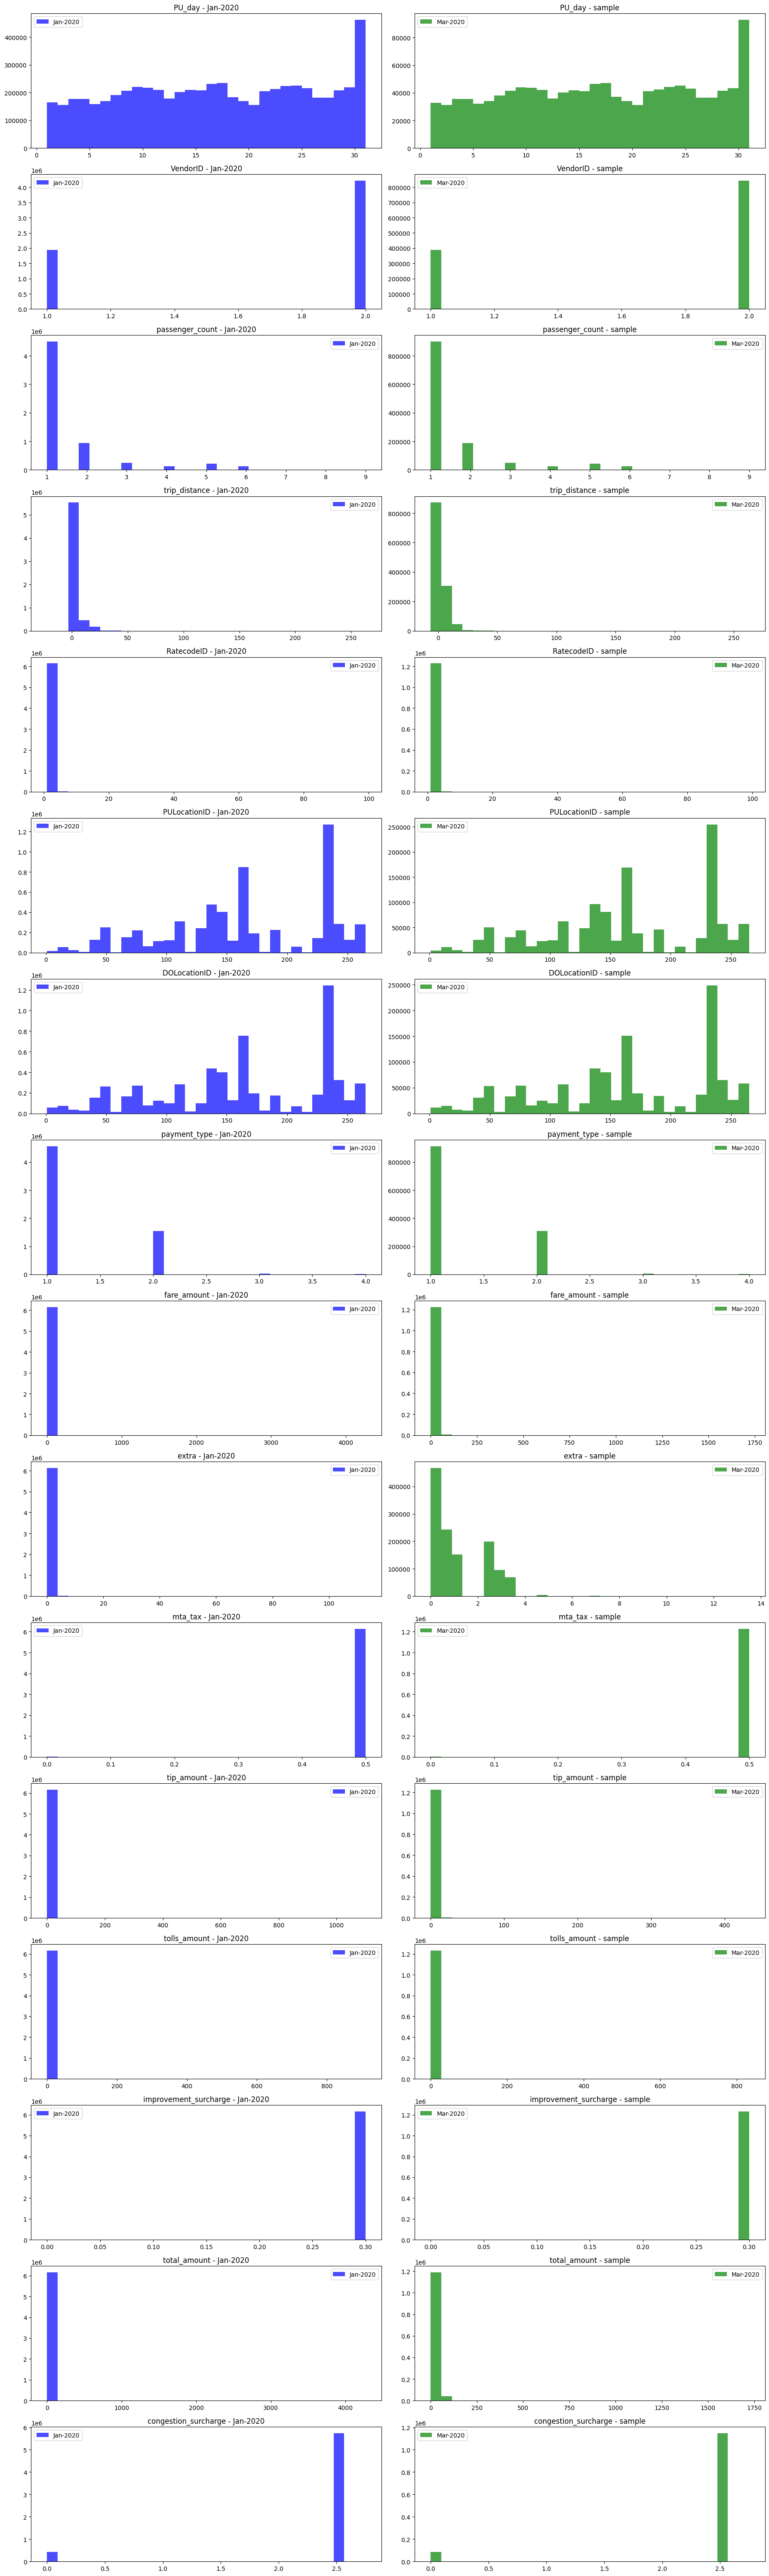

In [33]:
features = ['PU_day', 'VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
 'PULocationID', 'DOLocationID', 'payment_type',
 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
 'improvement_surcharge', 'total_amount', 'congestion_surcharge']

fig, axs = plt.subplots(nrows=len(features), ncols=2, figsize=(18, 60))

# Iterate through each feature and plot histograms
for i, feature in enumerate(features):
    axs[i, 0].hist(yellow_taxi[feature], bins=30, alpha=0.7, color='blue', label='Jan-2020')
    axs[i, 0].set_title(f'{feature} - Jan-2020')
    axs[i, 0].legend()

    axs[i, 1].hist(sample[feature], bins=30, alpha=0.7, color='green', label='Mar-2020')
    axs[i, 1].set_title(f'{feature} - sample')
    axs[i, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

- The dataset comprises an extensive 6,159,935 rows of taxi trip records.
- With 29 columns, including 'index', 'VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'DO_year', 'DO_month', 'DO_day', 'DO_hour', 'DO_minute', 'DO_second', 'PU_year', 'PU_month', 'PU_day', 'PU_hour', 'PU_minute', and 'PU_second'.
- This dataset underwent preprocessing steps identical to those used in a previous project, ensuring consistency and reliability.
- Since the dataset is too large, a sample was taken to manage computational load and analysis efficiency.
- Upon comparing the sample data with the original dataset, similar distribution patterns were observed, ensuring the sample's representativeness of the complete dataset.


## Merging weather and yellow taxi trip recoeds

In [34]:
ytt.get_info(sample)

Basic information about dataset
-------------------------------------------------------------------------------------------
Number of Rows : 1231987

RangeIndex(start=0, stop=1231987, step=1)

Number of columns :29

column Name : ['index' 'VendorID' 'passenger_count' 'trip_distance' 'RatecodeID'
 'store_and_fwd_flag' 'PULocationID' 'DOLocationID' 'payment_type'
 'fare_amount' 'extra' 'mta_tax' 'tip_amount' 'tolls_amount'
 'improvement_surcharge' 'total_amount' 'congestion_surcharge' 'DO_year'
 'DO_month' 'DO_day' 'DO_hour' 'DO_minute' 'DO_second' 'PU_year'
 'PU_month' 'PU_day' 'PU_hour' 'PU_minute' 'PU_second']

Columns which has null values :  {}



In [35]:
yellow_taxi = sample
weather['weather_day'] = weather['date'].dt.day

# Merge the datasets
merged_df = pd.merge(yellow_taxi, weather, left_on='PU_day', right_on='weather_day', how='left')

# Now, forward fill the weather columns to fill NaN values with the last valid value
weather_columns = ['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'pres']
merged_df[weather_columns] = merged_df[weather_columns].ffill()



In [36]:
mrg = Merged()
mrg.get_info(merged_df)

Basic information about dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231987 entries, 0 to 1231986
Data columns (total 39 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   index                  1231987 non-null  int64         
 1   VendorID               1231987 non-null  int64         
 2   passenger_count        1231987 non-null  float64       
 3   trip_distance          1231987 non-null  float64       
 4   RatecodeID             1231987 non-null  float64       
 5   store_and_fwd_flag     1231987 non-null  int64         
 6   PULocationID           1231987 non-null  int64         
 7   DOLocationID           1231987 non-null  int64         
 8   payment_type           1231987 non-null  int64         
 9   fare_amount            1231987 non-null  float64       
 10  extra                  1231987 non-null  float64       
 11  mta_tax                1231987 non-null  float64       
 

In [37]:
result = merged_df['PU_day'].equals(merged_df['weather_day'])

print(result)

True


In [38]:
del merged_df['weather_day']

- The 'day' column from the weather data and the 'pickup day' from the yellow taxi trip records were utilized for merging both datasets.
- To ensure continuity, the weather data's 'day' column was forward-filled to apply the same weather information to all subsequent rows until a new day's data appeared.
- Following the merge, as the 'day' column from the weather data and the 'pickup day' from the taxi trips were now identical, one of the duplicate columns was removed to streamline the dataset.

In [39]:
class DL_models():
  def split_scale(self, data):
    self.X = data.drop(['total_amount', 'date'], axis=1)  # Features
    self.y = data['total_amount']  # Target

    # Split the data into training and validation sets (80%/20% ratio)
    self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X, self.y, test_size=0.2, random_state=42)

    # Scale the features to the same range
    scaler = MinMaxScaler()
    self.X_train_scaled = scaler.fit_transform(self.X_train)
    self.X_val_scaled = scaler.transform(self.X_val)

  def MLP_model(self, data):
    self.split_scale(data)

    # Create MLPRegressor model
    mlp_model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=10)

    # Train the model
    mlp_model.fit(self.X_train_scaled, self.y_train)

    # Predictions
    mlp_y_pred_train = mlp_model.predict(self.X_train_scaled)
    mlp_y_pred_val = mlp_model.predict(self.X_val_scaled)

    # Calculate MSE and MAE
    mlp_train_mse = mean_squared_error(self.y_train, mlp_y_pred_train)
    mlp_val_mse = mean_squared_error(self.y_val, mlp_y_pred_val)

    mlp_train_mae = mean_absolute_error(self.y_train, mlp_y_pred_train)
    mlp_val_mae = mean_absolute_error(self.y_val, mlp_y_pred_val)

    # Print results
    print("MLPRegressor Model Results:")
    print("-" * 50)
    print("Train MSE: {:.4f}".format(mlp_train_mse))
    print("Val MSE: {:.4f}".format(mlp_val_mse))
    print("Train MAE: {:.4f}".format(mlp_train_mae))
    print("Val MAE: {:.4f}".format(mlp_val_mae))

    return mlp_train_mse, mlp_val_mse

  def LR_model(self, data):
    self.split_scale(data)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(self.X_train_scaled.shape[1],)))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(1))

    model.compile(loss='mae', optimizer='sgd', metrics=['mae'])

    lr_history = model.fit(self.X_train_scaled, self.y_train, validation_data=(self.X_val_scaled, self.y_val), epochs=100, batch_size=32)

    train_loss = lr_history.history['loss'][-1]
    val_loss = lr_history.history['val_loss'][-1]


    # Print results
    print("DNN Model Results:")
    print("-" * 50)
    print(f'Training Loss: {train_loss:.4f}')
    print(f'Validation Loss: {val_loss:.4f}')


    # Plot training loss vs validation loss
    plt.plot(lr_history.history['loss'], label='MLP Training Loss')
    plt.plot(lr_history.history['val_loss'], label='MLP Validation Loss')
    plt.title('LR Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return train_loss, val_loss

  def DNN_model(self, data):
    self.split_scale(data)
    # Define the input shape
    input_shape = self.X_train_scaled.shape[1]

    # Define the model
    inputs = Input(shape=(input_shape,))
    x = Dense(64, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)  # Adding one more hidden layer
    outputs = Dense(1)(x)  # Assuming it's a regression task

    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mse',  # Mean Squared Error for regression
                  metrics=['mae'])  # Mean Absolute Error

    # Fit the model
    history = model.fit(self.X_train_scaled, self.y_train, epochs=100, batch_size=32, validation_data=(self.X_val_scaled, self.y_val))

    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]

    # Make predictions on validation data
    y_pred = model.predict(self.X_val_scaled)

    # Calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE) for the predictions
    mse = mean_squared_error(self.y_val, y_pred)
    mae = mean_absolute_error(self.y_val, y_pred)

    # Print results
    print("DNN Model Results:")
    print("-" * 50)
    print(f'Training Loss: {train_loss:.4f}')
    print(f'Validation Loss: {val_loss:.4f}')


    # Plot training loss vs validation loss
    plt.plot(history.history['loss'], label='MLP Training Loss')
    plt.plot(history.history['val_loss'], label='MLP Validation Loss')
    plt.title('DNN Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return train_loss, val_loss, mse, mae




In [19]:
mdl = DL_models()
mlp_train_loss, mlp_val_loss = mdl.MLP_model(merged_df)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor Model Results:
--------------------------------------------------
Train MSE: 0.1802
Val MSE: 0.1734
Train MAE: 0.3942
Val MAE: 0.3948


Epoch 1/100
30800/30800 [==============================] - 68s 2ms/step - loss: 4.3682 - mae: 4.3682 - val_loss: 2.6773 - val_mae: 2.6773
Epoch 2/100
30800/30800 [==============================] - 67s 2ms/step - loss: 2.5755 - mae: 2.5755 - val_loss: 2.0537 - val_mae: 2.0537
Epoch 3/100
30800/30800 [==============================] - 67s 2ms/step - loss: 2.2036 - mae: 2.2036 - val_loss: 2.6245 - val_mae: 2.6245
Epoch 4/100
30800/30800 [==============================] - 67s 2ms/step - loss: 1.9128 - mae: 1.9128 - val_loss: 2.0788 - val_mae: 2.0788
Epoch 5/100
30800/30800 [==============================] - 71s 2ms/step - loss: 1.7122 - mae: 1.7122 - val_loss: 1.5601 - val_mae: 1.5601
Epoch 6/100
30800/30800 [==============================] - 81s 3ms/step - loss: 1.5881 - mae: 1.5881 - val_loss: 2.9931 - val_mae: 2.9931
Epoch 7/100
30800/30800 [==============================] - 70s 2ms/step - loss: 1.5128 - mae: 1.5128 - val_loss: 1.1764 - val_mae: 1.1764
Epoch 8/100
30800/30800 [=========

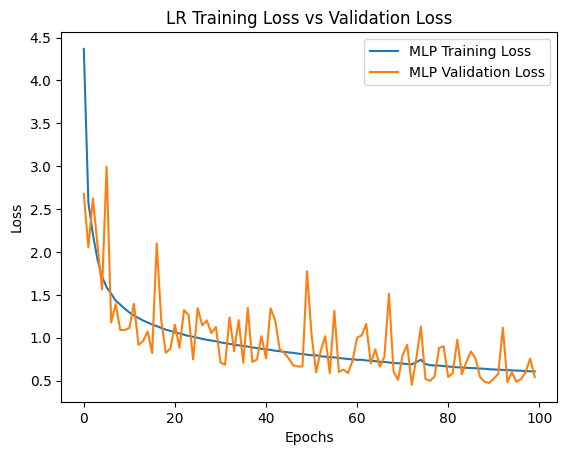

In [20]:
lr_train_loss, lr_val_loss = mdl.LR_model(merged_df)

In [40]:
mdl = DL_models()

Epoch 1/100
30800/30800 [==============================] - 82s 3ms/step - loss: 12.1677 - mae: 1.2237 - val_loss: 0.1693 - val_mae: 0.2359
Epoch 2/100
30800/30800 [==============================] - 93s 3ms/step - loss: 0.3239 - mae: 0.2823 - val_loss: 0.2378 - val_mae: 0.2530
Epoch 3/100
30800/30800 [==============================] - 91s 3ms/step - loss: 0.2104 - mae: 0.2323 - val_loss: 0.0300 - val_mae: 0.1174
Epoch 4/100
30800/30800 [==============================] - 93s 3ms/step - loss: 0.2429 - mae: 0.2042 - val_loss: 0.0231 - val_mae: 0.1336
Epoch 5/100
30800/30800 [==============================] - 82s 3ms/step - loss: 0.1884 - mae: 0.1991 - val_loss: 0.0097 - val_mae: 0.0739
Epoch 6/100
30800/30800 [==============================] - 82s 3ms/step - loss: 0.1352 - mae: 0.1831 - val_loss: 0.0368 - val_mae: 0.1666
Epoch 7/100
30800/30800 [==============================] - 86s 3ms/step - loss: 0.1779 - mae: 0.1786 - val_loss: 0.0040 - val_mae: 0.0339
Epoch 8/100
30800/30800 [========

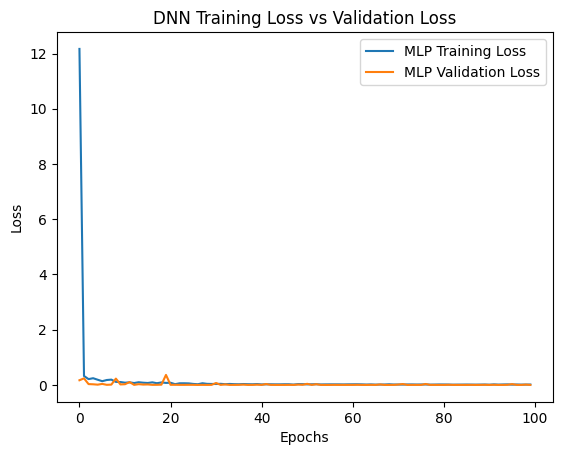

In [41]:
dnn_train_loss, dnn_val_loss, mse, mae= mdl.DNN_model(merged_df)

In [42]:
compare_dict = { 'Model' : ['MLP','LG','DNN'],
                'Method' : ['MLPRegressor', 'Sequential API', 'Functional API'],
                 'train_loss & val_loss' :[[mlp_train_loss, mlp_val_loss], [lr_train_loss, lr_val_loss], [dnn_train_loss, dnn_val_loss]],
                 'parameters' : ["hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=10'","loss='mae', optimizer='sgd', metrics=['mae']", "optimizer='adam', loss='mse', metrics=['mae']" ]

}
compare = pd.DataFrame(compare_dict)
compare['train_loss & val_loss'] = compare['train_loss & val_loss'].apply(lambda x: [round(num, 4) for num in x])

compare

,Model,Method,train_loss & val_loss,parameters
0,MLP,MLPRegressor,"[0.1802, 0.1734]","hidden_layer_sizes=(64, 32), activation='relu'..."
1,LG,Sequential API,"[0.6067, 0.542]","loss='mae', optimizer='sgd', metrics=['mae']"
2,DNN,Functional API,"[0.0138, 0.0001]","optimizer='adam', loss='mse', metrics=['mae']"


In [43]:
print("Prediction Loss on Validation Data for DNN model:")
print("-" * 50)
print(f"Validation MSE: {mse}")
print(f"Validation MAE: {mae}")


Prediction Loss on Validation Data for DNN model:
--------------------------------------------------
Validation MSE: 0.00011041336470914461
Validation MAE: 0.00483820136587104


In [ ]:
'''
import torch
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(input_size, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, num_classes),
    nn.Softmax(dim=1)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
'''